# **Physics Informed Neural Network!**

**Disclaimer**: large parts of the lab are taken from [this github repository](https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb) and [this one](https://github.com/jayroxis/PINNs) both based on the original work of [Raissi, Perdikaris and Karniadakis](https://doi.org/10.1016/j.jcp.2018.10.045) (original paper).

The obstacle that they found to publish the article state in the fact that the idea is very simple, but produce good result. 
- **+** Easy to code
- **+** Mesh free
- **-** Spectral problem with complicated problem


### **Definition**

Physics Informed Neural Netwoks (PINN) relates deep learning and Partial Differential Equations (PDEs). The main idea is not to purely rely on data, but to exploit the physical model (i.e. the _residual_ of the PDE) in the loss function.

**Pro**: the approach is totally mesh-free.

**Cons**: difficult to train for complicated problems.

### **The loss**
Let us be more specific:

The loss function of a PINN is made by: 
* boundary information
* residual information 

Let us suppose that the physical system we are studying is described by a PDE of the form
$
\mathcal R({w}(\mathbf x)) = 0
$

Namely, we want to fine a surrogate Neural Network $\tilde{w}$ that minimizes:

$$
    MSE  \doteq MSE_b + MSE_p.
$$
where
$$ 
        MSE_b \doteq \frac{1}{N_b} \sum_{k=1}^{N_b} | \tilde{w}(\mathbf x_k^b) - w(\mathbf x_k^b)|^2,
$$
hence, it is define in the boundary of the domain, for $\mathbf x_k^b \in \partial \Omega$.

Here, $MSE_b$ is the _boundary_ loss. While 
    $$
        MSE_{p} \doteq \frac{1}{N_p}\sum_{k=1}^{N_p}|\mathcal R(\tilde{w}(\mathbf x_k^p))|^2.
    $$

is the _physical_ (or residual) loss for $\mathbf x_k^p \in \Omega$, the points in the domain are the collocation problem.

Indeed, the system is
$$
\begin{cases}
PDE(\Omega) = 0 \\
bcs \text{ Neumann condition on the boundary}\\
\omega(\partial \Omega) = 0 \text{ Dirichlet condition }
\end{cases}
$$

### **A first Example: the 1D heat equation**

The physical model is given in the **space-time** domain $[0,2]\times[0,1]$: 

$$\frac{ du}{ dx} = \frac{2du}{dt}+u$$ 

with the following boundary (initial) condition $u(x,0)=6e^{-3x}$

- Independent variables: x,t (input)
- Dependent variables: u (outputs)

We have to find out u(x,t) for all x in range [0,2] and t in range [0,1]

Analytically, the solution is  $u(x,t) = 6e^{(-3x-2t)}$, that is our reference.

In [1]:
#### starting stuff ####

import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np

Let uf define the Neural Network!

**_Question time!_** what are the input and output dimension? Two dimension in input (`nn.Linear(2,5)`) and one dimension in output (`nn.Linear(5,1)`).

In [2]:
# Implementation of the Net
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(2,5) # Input
        self.hidden_layer1 = nn.Linear(5,5) # Hidden Layer
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1) # Output

    def forward(self, x,t): # Activation function
        input = torch.cat([x,t],axis=1) # combines the column array just to have only one input
        layer1_out = torch.sigmoid(self.input_layer(input))
        layer2_out = torch.sigmoid(self.hidden_layer1(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer2(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer3(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer4(layer4_out))
        output = self.output_layer(layer5_out)
        return output

In [3]:
### (2) Model
net = Net() # Call the function that we have just implemented
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters())

In [ ]:
## PDE as loss function. Thus would use the network which we call as u_theta
def R(x,t, net): # PDE(w)=R(w) that is the residual
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our R = du/dx - 2du/dt - u, we need du/dx and du/dt -- HOW TO PERFORM DERIVATIVES?
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0] # du/dx, taking the first element that is the derivative
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0] # du/dt

    # We are use u.sum() because when we have a tensor, we can transforme it in a scalar
    # So that we can performe the backpropagation on this scalar

    # PAY ATTENTION - In this part we can give u.sum() or not in relation on what we have to do!
    # Hence, pay attention on the different case!
    
    pde = u_x - 2*u_t - u
    
    return pde

In [ ]:
## Data from Boundary Conditions
# u(x,0)=6e^(-3x)
## BC just gives us datapoints for training

# BC tells us that for any x in range[0,2] and time=0, the value of u is given by 6e^(-3x)
# Take say 500 random numbers of x
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1)) # Define points in the boundary
t_bc = np.zeros((500,1)) # For every point in x, you have to associated a t point, 
                        # for now we set 0 so that they are along the line of the boundary
                        
# compute u based on BC
u_bc = 6*np.exp(-3*x_bc) # Using the solution

In [ ]:
### (3) Training / Fitting
iterations = 10000
for epoch in range(iterations): # Epoch == iteration, we're NOT working with mini-batch
    optimizer.zero_grad() # to make the gradients zero -- To not have accomulation (as always)
    
    # Loss based on boundary conditions
        # Variable() because we want to set that this is a variable, but ...
        # ... requires_grad=False, hence we do not want to compute the derivatives on this variable
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False) # Take evrithing to x_bc, without computing the gradient
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t) -- Computing only in the boundary point 
    mse_u = mse_cost_function(net_bc_out, pt_u_bc) # Compute the sum in the formula fo the MSE := MSEb
    
    # Loss based on PDE
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1)) # Compute some points inside the domain
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) # As before, set all element of t related to x
    all_zeros = np.zeros((500,1))

    # Definition of the variable
        # Here, we have requires_grad=True because we want to compute the gradient wrt 
        # these variabile when we call R function
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True) # The points that we have just define x_collocation
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False)
    
    f_out = R(pt_x_collocation, pt_t_collocation, net) # output of R(x,t) --> That we call here
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combining the loss functions
    loss = mse_u + mse_f # We can add a coefficient to put the loss (mse_f & mse_u) at the same order of magnitude
    
    
    loss.backward() 
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch,"Loss:",loss.item())

0 Loss: 2.372358560562134
1 Loss: 2.3710477352142334
2 Loss: 2.3698179721832275
3 Loss: 2.3686699867248535
4 Loss: 2.367607831954956
5 Loss: 2.3666281700134277
6 Loss: 2.3657355308532715
7 Loss: 2.3649256229400635
8 Loss: 2.3641998767852783
9 Loss: 2.363555908203125
10 Loss: 2.3629918098449707
11 Loss: 2.362504720687866
12 Loss: 2.362093687057495
13 Loss: 2.361751079559326
14 Loss: 2.3614749908447266
15 Loss: 2.3612594604492188
16 Loss: 2.3610973358154297
17 Loss: 2.3609836101531982
18 Loss: 2.360912561416626
19 Loss: 2.360875368118286
20 Loss: 2.3608667850494385
21 Loss: 2.3608810901641846
22 Loss: 2.3609089851379395
23 Loss: 2.360948324203491
24 Loss: 2.3609912395477295
25 Loss: 2.361034631729126
26 Loss: 2.3610761165618896
27 Loss: 2.3611104488372803
28 Loss: 2.3611369132995605
29 Loss: 2.361154317855835
30 Loss: 2.36116361618042
31 Loss: 2.36116361618042
32 Loss: 2.361154556274414
33 Loss: 2.3611392974853516
34 Loss: 2.361116647720337
35 Loss: 2.361091375350952
36 Loss: 2.361061573

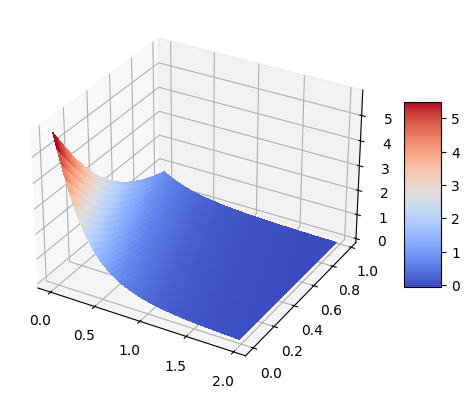

In [ ]:
# Plot some results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.arange(0,2,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)

## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)   
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

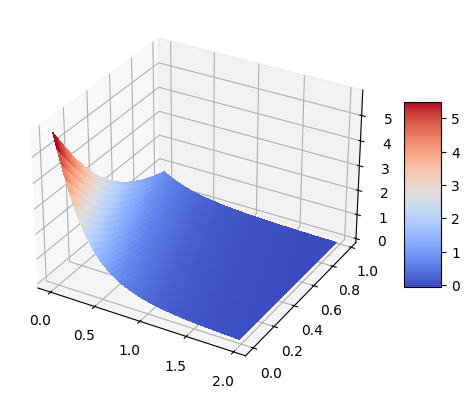

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).detach().numpy()
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).detach().numpy()
R_u = 6*np.exp(-3*pt_x - 2*pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# **Your Turn: let's change the equation**


Take a look to [this github repository](https://github.com/jayroxis/PINNs). The proposed tutorial is a bit more involved. 

We suggest to study it and to try to understand it line-by-line. Try to solve this equations that is a little bit more complicated.

It tries to represent the solution of the Burgers equation

$$
u_t + \lambda_1 uu_x - \lambda_2 u_{xx}
$$

for some fixed parameters $\lambda_1$ and $\lambda_2$.

Since no analytical solution is present, the code uses data provided by numerical simulations (that you can find in the folder data). Notice, that the solution changing varing the parameters, and we can consider them fixed or variable.

In [9]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import warnings

warnings.filterwarnings('ignore')

np.random.seed(1234)

In [10]:
# the deep neural network

# Build the constraction of the net, just in a contract for with some for loop
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict) ## layer, activation, layer, activation
        
    def forward(self, x): 
        out = self.layers(x) # self.layers := are the sequential of all the layer --> Just done in a compact way
        return out

In [ ]:
# the physics-guided neural network

# PNN definition
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float()
        self.ub = torch.tensor(ub).float()
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float()
        self.u = torch.tensor(u).float()
        
        # settings -- If you want to fix
        self.lambda_1 = torch.tensor([0.0], requires_grad=True)
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True)

        # settings -- If you want to find the value of lambda, you have just to set them as parameters
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers) # We call the net define before
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
        u = self.net_u(x, t)

        # Definition of first derivative wrt to t
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        # Definition of first derivative wrt to x
        u_x = torch.autograd.grad(
            u, x, # Here I do NOT put the sum, so I'm working with all the tensor and not just a scalar ...
            grad_outputs=torch.ones_like(u), # ... hence we have to tell that dT/dT=1 with T a variable that we define
            # Indeed, here we have just write that du/du=1 because we're working with the tensor,
            # and no more with the scalar how we did before writing u.sum()
            retain_graph=True,
            create_graph=True
        )[0]
        
        # Definition of second derivatives wrt x
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        self.optimizer.zero_grad()
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        self.dnn.train()
        for epoch in range(nIter):
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            loss.backward()
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), # The prediction is also for lambda -- we need some data
                        torch.exp(self.lambda_2).item()
                    )
                )
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float()
        t = torch.tensor(X[:, 1:2], requires_grad=True).float()

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [12]:
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('data/burgers_shock.mat') # Import the data

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

In [13]:
noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)

# At the end we reach a good approximation

Loss: 2.379245e-02, l1: 0.18653, l2: 0.00230
Loss: 1.510439e-02, l1: 0.53338, l2: 0.00260
Loss: 1.136508e-02, l1: 0.58937, l2: 0.00322
Loss: 7.742971e-03, l1: 0.70138, l2: 0.00377
Loss: 5.504389e-03, l1: 0.75810, l2: 0.00399
Loss: 4.173984e-03, l1: 0.80020, l2: 0.00479
Loss: 3.057414e-03, l1: 0.85740, l2: 0.00573
Loss: 1.870770e-03, l1: 0.91171, l2: 0.00614
Loss: 1.104523e-03, l1: 0.94429, l2: 0.00595
Loss: 6.797987e-04, l1: 0.96606, l2: 0.00546
Loss: 4.730221e-04, l1: 0.97706, l2: 0.00504
Loss: 3.102128e-04, l1: 0.97665, l2: 0.00454
Loss: 2.329755e-04, l1: 0.98243, l2: 0.00416
Loss: 1.885898e-04, l1: 0.98526, l2: 0.00384
Loss: 1.491945e-04, l1: 0.98392, l2: 0.00347
Loss: 1.337306e-04, l1: 0.98290, l2: 0.00332
Loss: 1.136881e-04, l1: 0.98878, l2: 0.00339
Loss: 8.821491e-05, l1: 0.98976, l2: 0.00324
Loss: 7.781447e-05, l1: 0.98876, l2: 0.00328
Loss: 6.914230e-05, l1: 0.98658, l2: 0.00325
Loss: 5.792868e-05, l1: 0.99498, l2: 0.00329
Loss: 5.094261e-05, l1: 0.99577, l2: 0.00325
Loss: 4.71

In [14]:
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  

Error u: 1.394462e-03
Error l1: 0.04777%
Error l2: 1.05141%
